## Description du projet kaggle : ASHRAE - Great Energy Predictor III


Nous utilisons un ensemble de données lié à ASHRAE - Great Energy Predictor III (combien d'énergie un bâtiment consommera-t-il?). L'objectif est de développer des modèles à partir des données 2016 de l'ASHRAE afin de mieux comprendre la consommation d'énergie mesurée des bâtiments dans les domaines suivants: eau glacée, électricité, eau chaude et compteurs de vapeur. Les données proviennent de plus de 1 000 bâtiments sur une période d'un an.



## Installer les packages 

On a utilisé les packages suivants dans notre projet:

numpy: numerical python pour la manipulation des matrices.

pandas: téléchargement et manipulation des DataFrame.  

seaborn: la visualization des graphes. 

LabelEncoder: c'est une classe utilisé pour convertir les variables catégoriques. 

keras: creation du modele reseau de neurone 

Et d'autre ....

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM,BatchNormalization,Dense ,Dropout
from keras.losses import mean_squared_error as mse_loss
from keras.optimizers import RMSprop, Adam
from keras import models
from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.optimizers import RMSprop,Adam
from keras import regularizers
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection  import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


# 1- Traitement des données 


## 1.1 Lire les données


In [2]:
test=pd.read_csv(r"C:\Users\LENOVO\Desktop\DB\test.csv")
train=pd.read_csv(r"C:\Users\LENOVO\Desktop\DB\train.csv")
building_metadata=pd.read_csv(r"C:\Users\LENOVO\Desktop\DB\building_metadata.csv")
weather_test=pd.read_csv(r"C:\Users\LENOVO\Desktop\DB\weather_test.csv")
weather_train=pd.read_csv(r"C:\Users\LENOVO\Desktop\DB\weather_train.csv")
print('Size of test', test.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building_metadata', building_metadata.shape)

Size of test (41697600, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building_metadata (1449, 6)


###### On a récupéré cette fonction "reduce memory" qui nous permet de réduire la taille de la memoire de chaque tableau 

 ====> Facilite le traitement des données

In [3]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [4]:
reduce_memory_usage(train)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


In [5]:
reduce_memory_usage(test)

Mem. usage decreased to 596.49 Mb (53.1% reduction)


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [6]:
reduce_memory_usage(weather_train)

Mem. usage decreased to  3.07 Mb (68.1% reduction)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.000000,NaN,-8.000000,NaN,NaN,180.0,5.699219
139769,15,2016-12-31 20:00:00,2.800781,2.0,-8.898438,NaN,1007.5,180.0,7.699219
139770,15,2016-12-31 21:00:00,2.800781,NaN,-7.199219,NaN,1007.5,180.0,5.101562
139771,15,2016-12-31 22:00:00,2.199219,NaN,-6.699219,NaN,1008.0,170.0,4.601562


In [7]:
reduce_memory_usage(weather_test)

Mem. usage decreased to  6.08 Mb (68.1% reduction)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609
...,...,...,...,...,...,...,...,...,...
277238,15,2018-12-31 19:00:00,3.300781,NaN,1.700195,NaN,1018.5,150.0,7.699219
277239,15,2018-12-31 20:00:00,2.800781,NaN,1.099609,NaN,1018.0,140.0,5.101562
277240,15,2018-12-31 21:00:00,2.800781,NaN,1.700195,-1.0,1017.0,140.0,6.199219
277241,15,2018-12-31 22:00:00,2.800781,NaN,2.199219,8.0,1016.0,140.0,5.101562


In [8]:
reduce_memory_usage(building_metadata)

Mem. usage decreased to  0.03 Mb (60.3% reduction)


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


###### Convertir la date sous la forme %Y-%m-%d

In [9]:
train["timestamp"] = pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')
test["timestamp"] = pd.to_datetime(test["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_test["timestamp"] = pd.to_datetime(weather_test["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"], format='%Y-%m-%d %H:%M:%S')


## 1.2 Analyse des données 

On va étudier la description de chaque tableau 

In [12]:
train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117122e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [13]:
test.describe()

,row_id,building_id,meter
count,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.075824e+02,6.642857e-01
std,1.203706e+07,4.297680e+02,9.278067e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.042440e+07,4.047500e+02,0.000000e+00
50%,2.084880e+07,9.000000e+02,0.000000e+00
75%,3.127320e+07,1.194250e+03,1.000000e+00
max,4.169760e+07,1.448000e+03,3.000000e+00


In [14]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [15]:
weather_test.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,277243.000000,277139.000000,136795.0,276916.000000,181655.0,255978.0,264873.0,276783.000000
mean,7.484654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.616959,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.093750,0.0,-31.593750,-1.0,972.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1011.5,80.0,2.099609
50%,7.000000,15.000000,2.0,8.398438,0.0,1016.5,190.0,3.099609
75%,12.000000,22.203125,4.0,15.000000,0.0,1021.0,280.0,4.601562
max,15.000000,48.312500,9.0,26.703125,597.0,1050.0,360.0,24.203125



Après avoir étudier la description de chaque tableau, on va par la suite faire l'analyse des valeurs manquantes ainsi les zéros de chaque variable.

In [15]:
def missing_zero_values(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isna().sum()
        mis_val_percent = 100 * df.isna().sum() / len(df)
        table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        table = table.rename(columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        table['Total MISSING ZERO Values'] = table['Zero Values'] + table['Missing Values']
        table['% Total MISSING ZERO Values'] = 100 * table['Total MISSING ZERO Values'] / len(df)
        print ("We have " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
               "There are " + str(table.shape[0]) +" columns that have missing values.")
        return table

missing_zero_values(weather_train)

We have 9 columns and 139773 Rows.
There are 9 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total MISSING ZERO Values,% Total MISSING ZERO Values
site_id,8784,0,0.000000,8784,6.284476
timestamp,0,0,0.000000,0,0.000000
air_temperature,812,55,0.039350,867,0.620291
cloud_coverage,33871,69173,49.489529,103044,73.722393
dew_temperature,2013,113,0.080845,2126,1.521038
precip_depth_1_hr,77910,50289,35.979052,128199,91.719431
sea_level_pressure,0,10618,7.596603,10618,7.596603
wind_direction,13154,6268,4.484414,19422,13.895388
wind_speed,13542,304,0.217496,13846,9.906062


In [16]:
missing_zero_values(weather_test)

We have 9 columns and 277243 Rows.
There are 9 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total MISSING ZERO Values,% Total MISSING ZERO Values
site_id,17520,0,0.000000,17520,6.319366
timestamp,0,0,0.000000,0,0.000000
air_temperature,1919,104,0.037512,2023,0.729685
cloud_coverage,64604,140448,50.658808,205052,73.961110
dew_temperature,3445,327,0.117947,3772,1.360539
precip_depth_1_hr,155955,95588,34.478057,251543,90.730154
sea_level_pressure,0,21265,7.670167,21265,7.670167
wind_direction,26052,12370,4.461790,38422,13.858601
wind_speed,26920,460,0.165919,27380,9.875813


In [17]:
missing_zero_values(train)

We have 4 columns and 20216100 Rows.
There are 4 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total MISSING ZERO Values,% Total MISSING ZERO Values
building_id,8784,0,0.0,8784,0.043451
meter,12060910,0,0.0,12060910,59.659925
timestamp,0,0,0.0,0,0.000000
meter_reading,1873976,0,0.0,1873976,9.269721


In [18]:
missing_zero_values(test)

We have 4 columns and 41697600 Rows.
There are 4 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total MISSING ZERO Values,% Total MISSING ZERO Values
row_id,1,0,0.0,1,0.000002
building_id,17520,0,0.0,17520,0.042017
meter,24755760,0,0.0,24755760,59.369748
timestamp,0,0,0.0,0,0.000000


In [19]:
missing_zero_values(building_metadata)

We have 6 columns and 1449 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total MISSING ZERO Values,% Total MISSING ZERO Values
site_id,105,0,0.000000,105,7.246377
building_id,1,0,0.000000,1,0.069013
primary_use,0,0,0.000000,0,0.000000
square_feet,0,0,0.000000,0,0.000000
year_built,0,774,53.416149,774,53.416149
floor_count,0,1094,75.500345,1094,75.500345


## 1-2 Observations des graphes

#### weather train/test

On va étudier les différents graphes de chaque tableau:

En premier lieu,on va faire une comparaison entre les weather train et test set de chaque variable 
 
 ===> On remarque qu'il n'y a pas une grande différences entre les courbes de weather train and test 

In [20]:
def plot(column):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.distplot(weather_train[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test[column].dropna(), color='red', ax=ax).set_title(column, fontsize=16)
    plt.legend(['train', 'test'])
    plt.show()

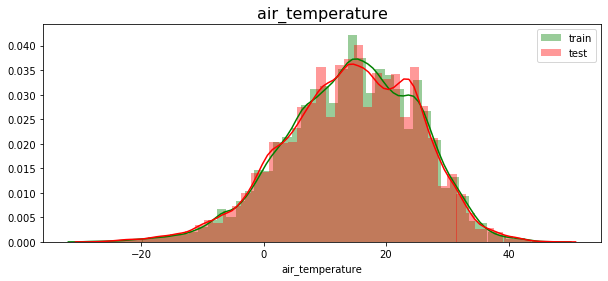

In [21]:
plot('air_temperature')

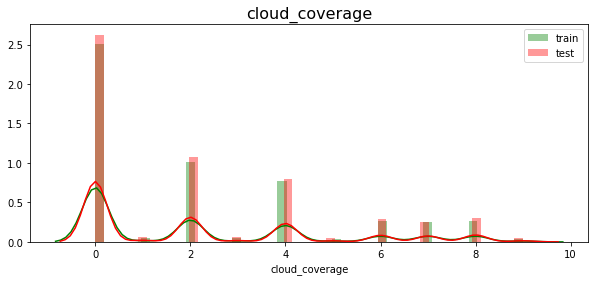

In [22]:
plot('cloud_coverage')

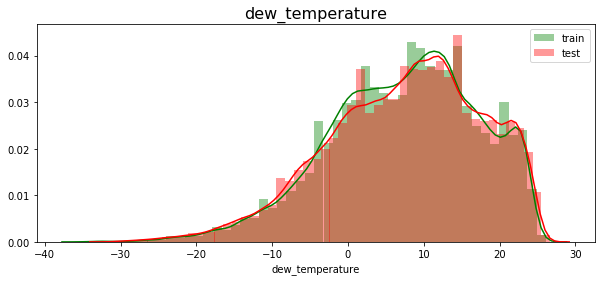

In [23]:
plot('dew_temperature')

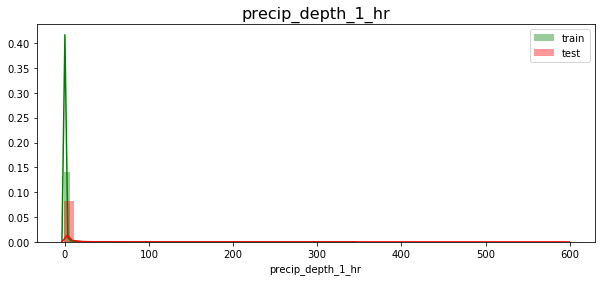

In [24]:
plot('precip_depth_1_hr')

### Etude des valeurs maquantes de weather test/train 

=====>On remarque que les variables cloud_coverage et precip ont plus grand valeurs maquantes, pareil pour les valeurs test weather

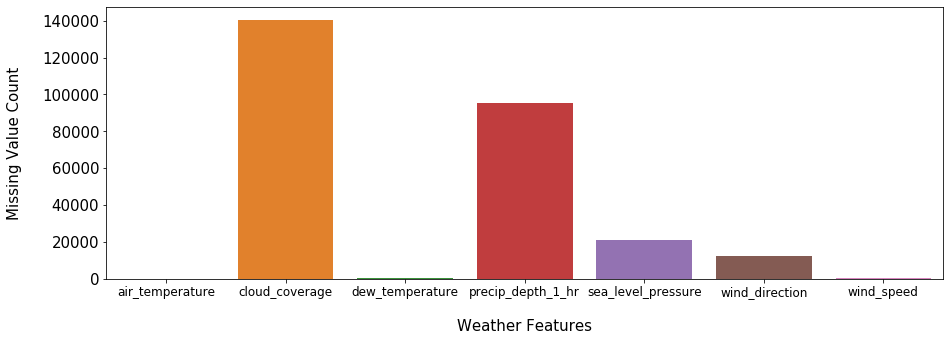

In [25]:
Weather = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

fig = plt.figure(figsize=(15, 5))
sns.barplot(x=weather_test[WEATHER_COLS].isnull().sum().index, y=weather_test[WEATHER_COLS].isnull().sum().values)

plt.xlabel('Weather Features', size=15, labelpad=20)
plt.ylabel('Missing Value Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)

plt.show()

#### Etude de meter_reading
Tracer une estimation de densité "meter_reading" de chaque type de meter (electricity, chilled water, steam, hot water)

Text(0.5, 1.0, 'Etude de la densité de reading meter pour chaque meter')

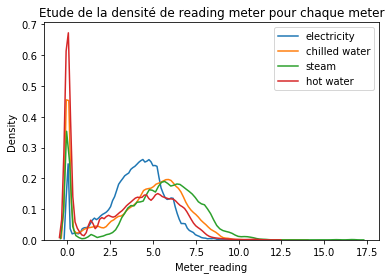

In [26]:
meters = sorted(train['meter'].unique().tolist()) 
#meters =[0,1,2,3]
# Graphe de la distribution du meter_reading distribution pour chaque meter 
for meter in meters:
    subset = train[train['meter'] == meter]
    sns.kdeplot(np.log1p(subset["meter_reading"]),label=meter)
plt.xlabel("Meter_reading")
plt.ylabel("Density")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("Etude de la densité de reading meter pour chaque meter")

##### visualisation de meter reading pour un batiment specifie par mois 
Apres la visualisation de meter reading de plusieurs batiment, j'ai constaté que le type de meter le plus utilisé parmi les 4 données est l'électricite  

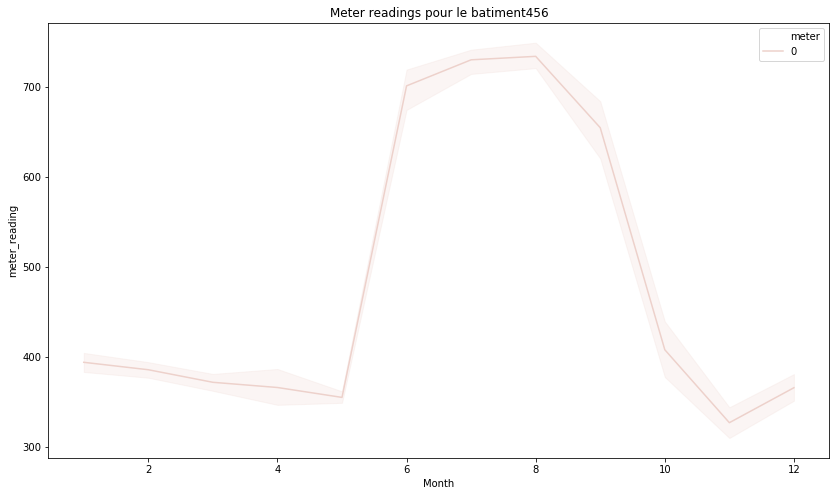

In [31]:
building_id =456
plt.figure(figsize=(14, 8))
ax = sns.lineplot(x="Month", y="meter_reading", hue="meter", data=train2[train2['building_id'] == building_id])
plt.title('Meter readings pour le batiment{}'.format(building_id))
plt.show()

## 1.3 Fusionner les tableaux data train 

On va faire la jointure de 3 tableaux 

====> Train et building metadata en 'building_id' puis on refait la jointure de ce dernier avec weather_train en 'site_id', 'timestamp'.


In [10]:
Train = train.merge(building_metadata, left_on='building_id', right_on='building_id' , how='left')
train1 =Train.merge(weather_train,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')
train1.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [29]:
train1.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [30]:
missing_zero_values(train1)

We have 16 columns and 20216100 Rows.
There are 16 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total MISSING ZERO Values,% Total MISSING ZERO Values
building_id,8784,0,0.000000,8784,0.043451
meter,12060910,0,0.000000,12060910,59.659925
timestamp,0,0,0.000000,0,0.000000
meter_reading,1873976,0,0.000000,1873976,9.269721
site_id,1076662,0,0.000000,1076662,5.325765
primary_use,0,0,0.000000,0,0.000000
square_feet,0,0,0.000000,0,0.000000
year_built,0,12127645,59.990033,12127645,59.990033
floor_count,0,16709167,82.652772,16709167,82.652772
air_temperature,141477,96658,0.478124,238135,1.177947


## 1.4 Fusionner les tableaux data test


Dans le meme esprit on fait pour les tableaux test 

In [ ]:
Test = test.merge(building_metadata, left_on='building_id', right_on='building_id' , how='left')
test1 =Test.merge(weather_test,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')

In [15]:
test1.columns 

Index(['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

Etudes des valeurs manquantes apres avoir faire la jointure des tableaux test 


In [59]:
missing_zero_values(test1)

Your selected dataframe has 16 columns and 41697600 Rows.
There are 16 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
row_id,1,0,0.000000,1,0.000002,int64
building_id,17520,0,0.000000,17520,0.042017,int64
meter,24755760,0,0.000000,24755760,59.369748,int64
timestamp,0,0,0.000000,0,0.000000,datetime64[ns]
site_id,2260080,0,0.000000,2260080,5.420168,uint8
primary_use,0,0,0.000000,0,0.000000,object
square_feet,0,0,0.000000,0,0.000000,uint32
year_built,0,0,0.000000,0,0.000000,uint16
floor_count,34444320,0,0.000000,34444320,82.605042,uint8
air_temperature,352433,221901,0.532167,574334,1.377379,float64


## 1.5 Drop columns
On va supprimer les colonnes qui n'ont pas d'utilite pour la prediction des donnees de meter reading

In [11]:
train1 = train1.drop(columns=["floor_count","year_built"])
test1 = test1.drop(columns=["floor_count", "year_built"])


In [12]:
train1.columns
train1.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
air_temperature         96658
cloud_coverage        8825365
dew_temperature        100140
precip_depth_1_hr     3749023
sea_level_pressure    1231669
wind_direction        1449048
wind_speed             143676
dtype: int64

## 1.6 Supprimer les fichiers inutiles 

Apres avoir fusionner les tableaux on va les supprimer pour liberer de l'espace dans la memoire

In [13]:
del test
del train
del building_metadata
del weather_test
del weather_train

## 1.7  Ajout des colonnes 
On va ajouter deux colonnes pour les moins et jours pour qu'on puisse construire des sequence par la suite 

In [15]:
train1['Month']=pd.DatetimeIndex(train1['timestamp']).month
test1['Month']=pd.DatetimeIndex(test1['timestamp']).month
train1['Day']=pd.DatetimeIndex(train1['timestamp']).day
test1['Day']=pd.DatetimeIndex(test1['timestamp']).day

## 1.8 Regrouper  des donnees

In [16]:
train2= train1.groupby([train1['site_id'],'meter',train1['building_id'],'primary_use',train1['Month'], train1['Day']]).agg({'meter_reading':'sum', 'air_temperature': 'mean', 'wind_speed': 'mean', 'precip_depth_1_hr': 'mean', 'cloud_coverage': 'mean', 'square_feet': 'mean', 'wind_direction':'mean', 'dew_temperature':'mean'})


In [17]:
train2=train2.reset_index()
train2.head()

,site_id,meter,building_id,primary_use,Month,Day,meter_reading,air_temperature,wind_speed,precip_depth_1_hr,cloud_coverage,square_feet,wind_direction,dew_temperature
0,0,0,0,Education,1,1,0.0,23.343750,1.854492,-0.173950,4.285156,7432,122.9375,20.015625
1,0,0,0,Education,1,2,0.0,19.531250,3.925781,-0.083313,5.667969,7432,167.5000,15.328125
2,0,0,0,Education,1,3,0.0,14.828125,5.000000,0.500000,8.000000,7432,276.7500,12.476562
3,0,0,0,Education,1,4,0.0,12.664062,4.285156,0.666504,2.427734,7432,318.2500,4.429688
4,0,0,0,Education,1,5,0.0,14.062500,6.257812,0.000000,1.333008,7432,142.1250,7.066406


## 1.9 Remplacer des valeurs manquantes 

In [77]:
train2.columns

Index(['meter', 'building_id', 'primary_use', 'Month', 'Day', 'meter_reading',
       'air_temperature', 'precip_depth_1_hr', 'wind_speed', 'dew_temperature',
       'cloud_coverage', 'square_feet'],
      dtype='object')

In [18]:
#ici on va remplir les missing value de notre ensemble de données avant de les utiliser dans notre model(avant nous allons modifié les types pour qu'on puisse utiliser"fillna")
train2['wind_speed'] = train2['wind_speed'].astype('float32')
train2['air_temperature'] = train2['air_temperature'].astype('float32')
train2['precip_depth_1_hr'] = train2['precip_depth_1_hr'].astype('float32')
train2['cloud_coverage'] = train2['cloud_coverage'].astype('float32')
train2['square_feet'] = train2['square_feet'].astype('float32')
train2['wind_direction'] = train2['wind_direction'].astype('float32')
train2['dew_temperature'] = train2['dew_temperature'].astype('float32')

train2['precip_depth_1_hr'].fillna(method='ffill', inplace = True)
train2['cloud_coverage'].fillna(method='ffill', inplace = True)
train2['wind_direction'].fillna(method='ffill', inplace = True)
train2['dew_temperature'].fillna(method='ffill', inplace = True)
train2['precip_depth_1_hr'].fillna(train2['precip_depth_1_hr'].mean(), inplace=True)
train2['cloud_coverage'].fillna(train2['cloud_coverage'].mean(), inplace=True)
train2['wind_speed'].fillna(train2['wind_speed'].mean(), inplace=True)
train2['air_temperature'].fillna(train2['air_temperature'].mean(), inplace=True)

In [19]:
#Pour verifier qu'iln'ya pas de valeurs manquantes 
train2.isna().sum()

site_id              0
meter                0
building_id          0
primary_use          0
Month                0
Day                  0
meter_reading        0
air_temperature      0
wind_speed           0
precip_depth_1_hr    0
cloud_coverage       0
square_feet          0
wind_direction       0
dew_temperature      0
dtype: int64

In [20]:
#On va trier le tableau par les variables suivantes ['site_id','building_id','meter','Month','Day'] pour faciliter la creation des sequences. 
train2.sort_values(by = ['site_id','building_id','meter','Month','Day'], ascending = [True,True,True,True,True])

,site_id,meter,building_id,primary_use,Month,Day,meter_reading,air_temperature,wind_speed,precip_depth_1_hr,cloud_coverage,square_feet,wind_direction,dew_temperature
0,0,0,0,Education,1,1,0.000000,23.343750,1.854492,-0.173950,4.285156,7432.0,122.9375,20.015625
1,0,0,0,Education,1,2,0.000000,19.531250,3.925781,-0.083313,5.667969,7432.0,167.5000,15.328125
2,0,0,0,Education,1,3,0.000000,14.828125,5.000000,0.500000,8.000000,7432.0,276.7500,12.476562
3,0,0,0,Education,1,4,0.000000,12.664062,4.285156,0.666504,2.427734,7432.0,318.2500,4.429688
4,0,0,0,Education,1,5,0.000000,14.062500,6.257812,0.000000,1.333008,7432.0,142.1250,7.066406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804621,15,0,1448,Office,12,27,75.949997,4.589844,5.640625,3.400391,3.500000,92271.0,222.5000,1.333008
804622,15,0,1448,Office,12,28,78.074997,-1.439453,4.464844,1.222656,3.500000,92271.0,266.5000,-4.667969
804623,15,0,1448,Office,12,29,76.650002,-1.112305,4.437500,0.000000,0.666504,92271.0,153.3750,-3.966797
804624,15,0,1448,Office,12,30,80.775002,-1.183594,5.925781,-1.000000,0.000000,92271.0,271.2500,-4.394531



## 1.9.1 Encoding categorical data

On va transformer les variables categoriques a des variables quantitatives 

In [22]:
Enco = LabelEncoder()
test2["primary_use"] = Enco.fit_transform(test2["primary_use"])
test2["primary_use"].describe()
train2["primary_use"] = Enco.fit_transform(train2["primary_use"])
train2["primary_use"].describe()

count    845701.000000
mean          3.156510
std           3.450462
min           0.000000
25%           0.000000
50%           1.000000
75%           6.000000
max          15.000000
Name: primary_use, dtype: float64

# 2 model: LSTM for Multi-Step Forecasting with multivariate input



In [151]:
#split data
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state= 45)

In [152]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [153]:
def make_model(input_dim=10,metrics=root_mean_squared_error,loss='mse',
        optimizer="rmsprop",drop_rate=0.5):
        model = Sequential()
        model.add(LSTM(128,return_sequences=True, input_shape=(None,input_dim)))
        model.add(Dropout(drop_rate))
        model.add(BatchNormalization())
        model.add(LSTM(128,return_sequences=False))
        model.add(BatchNormalization())
        model.add(Dropout(drop_rate))
        model.add(Dense(1))
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model

In [155]:
def run_model(model,x_train,y_train,epochs=50,batch_size=500,verbose=1,validation_data=(x_val,y_val),callbacks =None):
        x_train = x_train.values[:]
        x_train= x_train.reshape((x_train.shape[0],1,x_train.shape[-1]))
        y_train = np.log1p(y_train)
        if validation_data != None:
            x_val = validation_data[0].values[:]
            x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[-1]))
            y_val = np.log1p(validation_data[-1])
        return model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=(x_val,y_val),callbacks=callbacks)

## EarlyStopping
Un problème avec l'entraînement des réseaux de neurones réside dans le choix du nombre d'époques d'entraînement à utiliser.
Trop d'époques peuvent conduire à un sur-ajustement de l'ensemble de données d'apprentissage, tandis que trop peu peuvent
entraîner un modèle de sous-équipement.

L'arrêt précoce (EarlyStopping) est une méthode qui vous permet de spécifier un grand nombre arbitraire d'époques d'apprentissage et d'arrêter l'entraînement une fois que les performances du modèle cessent de s'améliorer sur un ensemble de données de validation d'attente.

In [157]:
es = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0001, patience=5, verbose=True, mode='auto')

In [158]:
model = make_model(input_dim=x_train.shape[-1],drop_rate=0.5)
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, None, 128)         72704     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 128)         512       
_________________________________________________________________
lstm_47 (LSTM)               (None, 128)               131584    
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

In [159]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [160]:
history = run_model(model,x_train,y_train,epochs=30,batch_size=500,verbose=1,validation_data=(x_val,y_val), callbacks =[es])

Train on 676560 samples, validate on 169141 samples
Epoch 1/30
676560/676560 [==============================] - 79s 117us/step - loss: 11.2921 - root_mean_squared_error: 3.1382 - val_loss: 6.2389 - val_root_mean_squared_error: 2.4956
Epoch 2/30
676560/676560 [==============================] - 75s 110us/step - loss: 6.7872 - root_mean_squared_error: 2.6025 - val_loss: 6.6546 - val_root_mean_squared_error: 2.5784
Epoch 3/30
676560/676560 [==============================] - 72s 106us/step - loss: 6.8785 - root_mean_squared_error: 2.6198 - val_loss: 6.8783 - val_root_mean_squared_error: 2.6214
Epoch 4/30
676560/676560 [==============================] - 74s 110us/step - loss: 6.9416 - root_mean_squared_error: 2.6326 - val_loss: 6.8015 - val_root_mean_squared_error: 2.6059
Epoch 5/30
676560/676560 [==============================] - 75s 110us/step - loss: 6.9047 - root_mean_squared_error: 2.6250 - val_loss: 6.7773 - val_root_mean_squared_error: 2.6015
Epoch 6/30
676560/676560 [================